In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
input_path = Path('/user/data/coins/classification_dataset/all/')
im_size = 320

In [3]:
image_files = list(input_path.glob('*.jpg'))

In [4]:
def read_file(fname):
    # Read image
    im = Image.open(fname)

    # Resize
    im.thumbnail((im_size, im_size))

    # Convert to numpy array
    im_array = np.asarray(im)

    # Get target
    target = int(fname.stem.split('_')[0])

    return im_array, target

In [5]:
images = []
targets = []

for image_file in tqdm_notebook(image_files):
    image, target = read_file(image_file)
    
    images.append(image)
    targets.append(target)

In [6]:
X = (np.array(images).astype(np.float32) / 127.5) - 1
y_cls = np.array(targets)

In [7]:
X.shape, y_cls.shape

((3059, 240, 320, 3), (3059,))

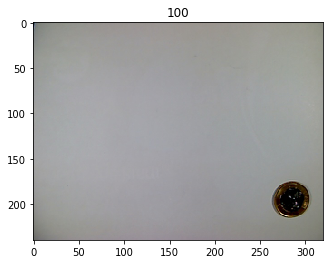

In [8]:
i = 555
plt.imshow(np.uint8((X[i] + 1) * 127.5))
plt.title(str(y_cls[i]));

In [9]:
coins_ids = {
    5: 0,
    10: 1,
    25: 2,
    50: 3,
    100: 4
}

ids_coins = [5, 10, 25, 50, 100]

y = np.array([coins_ids[coin] for coin in y_cls])

In [10]:
X_train, X_valid, y_train, y_valid, fname_train, fname_valid = train_test_split(
    X, y, image_files, test_size=0.2, random_state=42)

In [11]:
im_width = X.shape[2]
im_height = X.shape[1]

im_width, im_height

(320, 240)

# Keras

In [12]:
from keras.layers import Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [13]:
model = Sequential()

# CNN network
model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(im_height, im_width, 3)) )
model.add( MaxPool2D(2) )

model.add( Conv2D(32, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(128, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(256, 3, activation='relu', padding='same') )

# Transition between CNN and MLP
model.add( GlobalAvgPool2D() )

# MLP network
model.add( Dense(256, activation='relu') )

model.add( Dense(5, activation='softmax') )

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 320, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 160, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 80, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 40, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 40, 128)      

In [14]:
optim = Adam(lr=1e-3)
model.compile(optim, 'sparse_categorical_crossentropy', metrics=['acc'])

In [15]:
callbacks = [
    ReduceLROnPlateau(patience=5, factor=0.1, verbose=True),
    ModelCheckpoint('best.model', save_best_only=True),
    EarlyStopping(patience=12)
]

history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_valid, y_valid), batch_size=32,
                   callbacks=callbacks)

Train on 2447 samples, validate on 612 samples
Epoch 1/2000
2447/2447 [==============================] - 9s 3ms/step - loss: 1.5955 - acc: 0.2268 - val_loss: 1.4404 - val_acc: 0.4967
Epoch 2/2000
2447/2447 [==============================] - 5s 2ms/step - loss: 1.3161 - acc: 0.4765 - val_loss: 1.1733 - val_acc: 0.4902
Epoch 3/2000
2447/2447 [==============================] - 5s 2ms/step - loss: 1.0095 - acc: 0.6183 - val_loss: 0.8032 - val_acc: 0.7124
Epoch 4/2000
2447/2447 [==============================] - 5s 2ms/step - loss: 0.8307 - acc: 0.6947 - val_loss: 0.8825 - val_acc: 0.5964
Epoch 5/2000
2447/2447 [==============================] - 5s 2ms/step - loss: 0.6814 - acc: 0.7617 - val_loss: 0.8054 - val_acc: 0.6765
Epoch 6/2000
2447/2447 [==============================] - 5s 2ms/step - loss: 0.7073 - acc: 0.7474 - val_loss: 0.6858 - val_acc: 0.7925
Epoch 7/2000
2447/2447 [==============================] - 5s 2ms/step - loss: 0.5161 - acc: 0.8398 - val_loss: 0.5082 - val_acc: 0.8284
E

In [16]:
df_history = pd.DataFrame(history.history)

(0.9, 1)

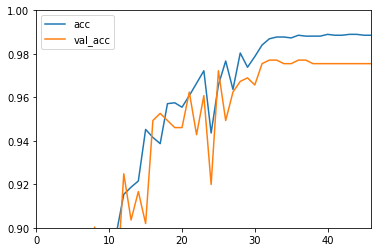

In [17]:
ax = df_history[['acc', 'val_acc']].plot()
ax.set_ylim(0.9, 1)

In [18]:
df_history['val_acc'].max()

0.9771241545677185

In [19]:
model.load_weights('best.model')

In [20]:
model.evaluate(X_valid, y_valid)

612/612 [==============================] - 1s 1ms/step


[0.08377021031295942, 0.9754902124404907]

# Evaluate results

In [21]:
y_pred = model.predict(X_valid)

In [22]:
y_pred_cls = y_pred.argmax(1)

In [23]:
errors = np.where(y_pred_cls != y_valid)[0]
errors

array([ 36,  67,  88, 106, 130, 155, 177, 235, 265, 273, 291, 329, 384,
       454, 495])

In [ ]:
i = 55
plt.figure(figsize=(10, 10))
im = Image.open(fname_valid[i])
plt.imshow(np.uint8(im), interpolation='bilinear')
plt.title('Class: {}, Predicted: {}'.format(ids_coins[y_valid[i]], ids_coins[np.argmax(y_pred[i])]));